In [339]:
"""
pygraph.py

Un petit module pour créer des graphes (non orienté, orienté ou bi-partie)
Avec visualisation via Graphviz et possibilité de modifier quelques propriétés visuelles (couleur, forme, étiquette)

Auteur  : Sébastien Hoarau
Date    : 2021-08
Licence : CC BY-NC-SA 4.0 http://creativecommons.org/licenses/by-nc-sa/4.0/
Site    : gitlab.com/sebhoa/pygraph/

TODO
----
    - Plus de tests. Il reste probablement beaucoup de bugs à corriger
    - Ajouter d'autres algorithmes sur les graphes
    - traiter des graphes valués
"""

import graphviz as gv
import networkx as nx
import random
import string
import json

# ----------
# CONSTANTES

# -- about shape and label
#
CIRCLE = 'circle'
SQUARE = 'square'
NOLABEL = ''

# Revoir plus tard le coup des emoji comme label
ANIMALS = ''.join([chr(n) for n in range(0x1f400,0x1f440)])
PEOPLE1 = ''.join([chr(n) for n in range(0x1f9d1, 0x1f9d5)]) 
PEOPLE2 = ''.join([chr(n) for n in range(0x1f466, 0x1f46a)])
PEOPLE3 = ''.join([chr(n) for n in range(0x1f474, 0x1f477)])
PEOPLE4 = chr(0x1f471)

# -- about colors

# color_id
WHITE = -1
LIGHTBLUE = 0
LEMONCHIFFON = 1
PINK1 = 2
LIGHTGREEN = 3
IVORY2 = 4
SIENNA1 = 5
BLACK = 6


# tuple of colors
COLORS = 'lightblue', 'lemonchiffon', 'pink1', 'lightgreen', 'ivory2', 'sienna1', 'black', 'white'

# -- about edges and nodes dimensions
ARROWSIZE = '0.5'
NODE_MARGIN = '0.02'
NODE_WIDTH = '0.3'
NODE_HEIGHT = '0.3'
SMALL_NODE_WIDTH = '0.1'
SMALL_NODE_HEIGHT = '0.1'

# -----------
# LES CLASSES

class NodeView:
    """
    La classe NodeView modélise les propriétés d'un noeud pour sa visualisation. 
    Cet objet est stocké comme information supplémentaire du modèle networkx
    
    Parameters
    ----------
        gv : graphviz.Graph | graphviz.Digraph
            la vue à laquelle cette vue noeud est rattachée
        node_id : int
            numéro identifiant le sommet
        color_id : int
            un numéro de couleur (valeur par défaut -1)
    """

    def __init__(self, gv, node_id, color_id=WHITE):        
        self.__gv = gv
        self.__id = node_id 
        self.__color_id = color_id
        self.__pos = None
        self.__label = str(node_id)
        self.__ech = 1
        self.__width = NODE_WIDTH
    
    # Public attributes
    
    @property
    def id(self):
        return self.__id
        
    @property
    def color_id(self):
        return self.__color_id
    
    @color_id.setter
    def color_id(self, color_id):
        self.__color_id = min(max(-len(COLORS), color_id), len(COLORS)-1)
    
    @property
    def pos(self):
        return self.__pos
    
    @pos.setter
    def pos(self, pos):
        self.__pos = pos
        
    @property
    def width(self):
        return self.__width
    
    @width.setter
    def width(self, width):
        self.__width = width

    @property
    def ech(self):
        return self.__ech
    
    @ech.setter
    def ech(self, ech):
        self.__ech = ech

    @property
    def label(self):
        return self.__label
    
    @label.setter
    def label(self, label):
        if not isinstance(label, str):
            label = str(self.id)
        self.__label = label
    
    @property
    def gv(self):
        return self.__gv
   
    
    # View modification methods
    
    def create(self):
        self.__gv.node(str(self.id), self.label, shape=CIRCLE, style='filled', fillcolor=self.color(), width=NODE_WIDTH, height=NODE_HEIGHT)
    
    
    # -- about labels
    
    def label_on(self, label = None):
        if label == None:
            self.__gv.node(str(self.id), self.label)
        else:
            self.__gv.node(str(self.id), label)

    def label_off(self):
        self.__gv.node(str(self.id), NOLABEL)
        
    def label_on_side(self, label = None):
        if label == None:
            self.__gv.node(str(self.id), xlabel=self.label)
        else:
            self.__gv.node(str(self.id), xlabel=label)

    def label_off_side(self):
        self.__gv.node(str(self.id), xlabel=NOLABEL)
        
    
    # -- about colors
    
    def color(self):
        return COLORS[self.color_id]
    
    def color_on(self, color=None):
        if isinstance(color, str):
            color_str = color
        elif isinstance(color, int):
            try:
                color_str = COLORS[color]
            except:
                color_str = COLORS[WHITE]
        else:
            color_str = self.color()
        self.__gv.node(str(self.id), style='filled', fillcolor=color_str)

    def color_off(self):
        self.__gv.node(str(self.id), style='filled', fillcolor=COLORS[WHITE])
        
        
    # -- about position and size
    
    def _is_positioned(self):
        return self.pos is not None

    def move(self, dx, dy):
        if self._is_positioned():
            self.pos = self.pos[0] + dx, self.pos[1] + dy

    def place(self, ech=None):
        if self._is_positioned():
            ech = self.ech if ech is None else ech
            self.ech = ech
            x, y = self.pos
            pos = f'{x*ech},{y*ech}!'
            self.__gv.node(str(self.id), pos=pos)
            
        
    def size(self, *dim):
        if len(dim) == 0:
            w, h = NODE_WIDTH, NODE_HEIGHT
            self.width = NODE_WIDTH
        elif len(dim) == 1:
            w, h = dim[0], dim[0]
            self.width = dim[0]
        else:
            w, h = dim
            width = dim[0]
        self.__gv.node(str(self.id), width=str(w), height=str(h))

    
class EdgeView:
    """
    La classe EdgeView modélise les propriétés d'une arête ou d'un arc pour sa visualisation. 
    Cet objet est stocké comme information supplémentaire du modèle networkx
    
    Parameters
    ----------
        gv : graphviz.Graph | graphviz.Digraph
            la vue à laquelle cette vue noeud est rattachée
        edge : 
            couple de node_id identifiant l'arc/arête
        color_id : int
            un numéro de couleur (valeur par défaut -1)
        weight : 
            La dimension l'attribut shape circle qui est égale à la hauteur
    """

    def __init__(self, gv, node_src, node_dst, weight=None, color_id=BLACK):        
        self.__gv = gv
        self.__edge = (node_src, node_dst)
        self.__color_id = color_id
        self.__weight = weight
        
    # Public attributes
    
    @property
    def edge(self):
        return self.__edge
        
    @property
    def color_id(self):
        return self.__color_id
    
    @color_id.setter
    def color_id(self, color_id):
        self.__color_id = min(max(-len(COLORS), color_id), len(COLORS)-1)

    @property
    def weight(self):
        return self.__weight
    
    @weight.setter
    def weight(self, weight):
        if not isinstance(weight, str):
            weight = str(self.weight)
        self.__weight = weight
    
    @property
    def gv(self):
        return self.__gv
   
    
    # View modification methods
    
    def create(self):
        if not self.weight:
            self.__gv.edge(str(self.edge[0]), str(self.edge[1]), style='filled', color=self.color())
        else:
            self.__gv.edge(str(self.edge[0]), str(self.edge[1]), str(self.weight), style='filled', color=self.color())
        
    
    # -- about colors
    
    def color(self):
        return COLORS[self.color_id]
    
    def color_on(self, color=None):
        if isinstance(color, str):
            color_str = color
        elif isinstance(color, int):
            try:
                color_str = COLORS[color]
            except:
                color_str = COLORS[BLACK]
        else:
            color_str = self.color()
        self.gv.edge(str(self.edge[0]), str(self.edge[1]), str(self.weight), style='filled', color=color_str)

    def color_off(self):
        self.__gv.edge(str(self.edge[0]), str(self.edge[1]), style='filled', color=COLORS[BLACK])
        
            
class Graph:
    """
    class Graph modélise un graphe non orienté dont le propriétés importantes sont :
    - model : un objet graphe au sens de networkx
    - view : un objet graphe au sens de graphviz
        
    Parameters:
    -----------
        nodes_count : int
            le nombre de sommets du graphe (par défaut 0)
        random : bool
            un flag pour savoir si le graphe généré est aléatoire. Si True alors le modèle sera 
            nx.erdos_renyi_graph(nodes_count, 0.5)
        engine : str
            le moteur de rendu (au sens de graphviz) ; par défaut 'neato'
    
    Note:
    -----
        Les autres paramètres ne devraient pas être utilisés : ils servent pour la création
        des graphes orientés et des graphes bi-partie
    """
        
    def __init__(self, nodes_count=0, random=False, directed=False, bipartite=False, n1=0, n2=0, engine='neato', strict=False):
        if random:
            self.__model = nx.erdos_renyi_graph(nodes_count, 0.5)
        elif directed:
            self.__model = nx.DiGraph()
        elif bipartite:
            self.__model = nx.complete_bipartite_graph(n1, n2)
        else:
            self.__model = nx.Graph()
        if directed:
            self.__view = gv.Digraph(engine=engine, strict=strict, edge_attr={'arrowsize':ARROWSIZE}, node_attr={'fixedsize':'true', 'width':NODE_WIDTH, 'height':NODE_HEIGHT, 'margin':NODE_MARGIN})
        else:
            self.__view = gv.Graph(engine=engine, strict=strict, node_attr={'fixedsize':'true', 'width':NODE_WIDTH, 'height':NODE_HEIGHT, 'margin':NODE_MARGIN})
        self.__engine = engine
        self.__model.add_nodes_from([node_id, {'view': None}] for node_id in range(nodes_count))
        self.init_view()
        
    
    @property
    def model(self):
        return self.__model
    
    @model.setter
    def model(self, model):
        self.__model = model
    
    @property
    def view(self):
        return self.__view
    
    @view.setter
    def view(self, view):
        self.__view = view

    @property
    def engine(self):
        return self.__engine
    
    @engine.setter
    def engine(self, engine):
        self.__engine = engine
    
    # MODEL METHODS
    
    # -- about information
    
    def node_ids(self):
        return self.model.nodes
    
    def edges(self):
        return self.model.edges
    
    def edge_informations(self, s1, s2):
        return self.model.adj[s1][s2]
    
    def number_of_nodes(self):
        return self.model.number_of_nodes()

    def number_of_edges(self):
        return self.model.number_of_edges()
        
    # -- about adding elements
    
    def add_nodes(self, nodes_count=1):
        first = 0 if self.number_of_nodes() == 0 else max(self.node_ids()) + 1
        for new_id in range(first, first+nodes_count):
            self.model.add_nodes_from([(new_id, {'g':self, 'view': NodeView(self.view, new_id)})])
            self.node_view(new_id).create()

    def add_edge(self, s1, s2, weight=None):
        self.model.add_edge(s1, s2, weight=weight, view=EdgeView(self.view, s1, s2, weight))
        self.edge_view(s1, s2).create()
    
    def add_edges_from(self, iterable=None):
        for s in iterable:
            s1, s2, *args = s
            self.add_edge(s1, s2, *args)
    
    # -- about removing elements

    def remove_node(self, node_id):
        if node_id in self.node_ids():
            self.model.remove_node(node_id)
            self.reset_view()
    
    def remove_nodes_from(self, iterable):
        self.model.remove_nodes_from(iterable)
        self.reset_view()

    def remove_edge(self, s1, s2):
        self.model.remove_edge(s1, s2)
        self.reset_view()
    
    def remove_edges_from(self, iterable):
        self.model.remove_edges_from(iterable)
        self.reset_view()
    
    def remove_random_edges(self, edges_count):
        edges_count = min(edges_count, self.number_of_edges())
        list_of_edges = list(self.edges())
        random.shuffle(list_of_edges)
        self.remove_edges_from(list_of_edges[:edges_count])
        
    # -- copy of graph
    
    def copy(self):
        nodes_count = self.number_of_nodes()
        g = Graph(nodes_count, engine=self.engine)
        g.add_edges_from(self.edges())    
        g.same_position_as(self)
        return g

    # -- load a complete json file graph description
    def load_json(self, filename, encoding='utf-8'):
        with open(filename, 'r', encoding=encoding) as jsonfile:
            properties = json.load(jsonfile)
        if 'nodes'  in properties:
            self.add_nodes(properties['nodes'])
        if 'edges' in properties:
            self.add_edges_from(properties['edges'])
        if 'labels' in properties:
            self.set_labels(properties['labels'])
            self.label_on()
        if 'position' in properties:
            self.position(properties['position'])
        if 'scale' in properties:
            self.scale(properties['scale'])

    # -- save a complete json file from graph
    
    # TODO
        
                    
    # -- other informations usefull for a lot of graphs algorithms
    
    def degree(self, node_id):
        return self.model.degree(node_id)
    
    def neighbors(self, node_id):
        return self.model.neighbors(node_id)
    
    
    # VIEW METHODS
    
    def node_view(self, node_id):
        return self.model.nodes[node_id]['view']
    
    def edge_view(self, node_src, node_dst):
        return self.model.edges[node_src, node_dst]['view']
    
    def init_view(self):
        self.init_nodes_view()
        self.init_edges_view()
        self.view_is_up_to_date = True
        
    def reset_view(self, engine=None, strict=False):
        engine = self.engine if engine is None else engine
        d_position = self.export_position()
        self.__view = gv.Graph(engine=engine, format='svg', strict=strict, node_attr={'fixedsize':'true', 'width':NODE_WIDTH, 'height':NODE_HEIGHT, 'margin':NODE_MARGIN})
        self.init_view()
        self.import_position(d_position)
        
    def init_nodes_view(self):
        for node_id in self.node_ids():
            self.model.nodes[node_id]['view'] = NodeView(self.view, node_id)
            self.node_view(node_id).create()

    def init_edges_view(self):
        for s1, s2 in self.edges():
            information = self.edge_informations(s1, s2)
            weight = information.get('weight', None)
            if s2 > s1:
                self.model.edges[s1, s2]['weight'] = weight
                self.model.edges[s1, s2]['view'] = EdgeView(self.view, s1, s2, weight)
                self.edge_view(s1, s2).create()
            
    # -- about nodes positionning and resizing
    
    def position(self, iterable, ech=1):
        for node_id, *pos in iterable:
            self.node_view(node_id).pos = pos
        self.scale(ech)
        
    def scale(self, ech=None):
        for node_id in self.node_ids():
            self.node_view(node_id).place(ech)
        
    def same_position_as(self, g):
        for node_id in g.node_ids():
            if node_id in self.node_ids():
                node_view = self.node_view(node_id) 
                node_view.pos = g.node_view(node_id).pos
                node_view.ech = g.node_view(node_id).ech
                node_view.place()

    def _rec_move(self, node_ids, seen, dx, dy):
        if node_ids:
            node_id = node_ids.pop()
            self.node_view(node_id).move(dx, dy)
            seen.add(node_id)
            for v_id in self.neighbors(node_id):
                if v_id not in seen:
                    node_ids.add(v_id)
                    self._rec_move(node_ids, seen, dx, dy)
                    
    def move(self, node_id, dx, dy, group=False):
        if group:
            self._rec_move({node_id}, set(), dx, dy)
        else:
            self.node_view(node_id).move(dx, dy)
        self.scale()
    
    def resize(self, *dim, node_id=None):
        if node_id is None:
            for node_id in self.node_ids():
                self.node_view(node_id).size(*dim)
                if float(self.node_view(node_id).width) < 0.25:
                    self.node_view(node_id).label_off()
                    self.node_view(node_id).label_on_side(self.node_view(node_id).label)
                else:
                    self.node_view(node_id).label_on(self.node_view(node_id).label)
                    self.node_view(node_id).label_off_side()
        else:
            self.node_view(node_id).size(*dim)
            if float(self.node_view(node_id).width) < 0.25:
                self.node_view(node_id).label_off()
                self.node_view(node_id).label_on_side(self.node_view(node_id).label)
            else:
                self.node_view(node_id).label_on(self.node_view(node_id).label)
                self.node_view(node_id).label_off_side()
            
    def export_position(self):
        lnodes = list(self.node_ids())
        d = {node_id:self.node_view(node_id).pos for node_id in self.node_ids()}
        d['ech'] = self.node_view(lnodes[0]).ech if lnodes else 1
        return d

    def import_position(self, d_position):
        ech = d_position['ech']
        for node_id in self.node_ids():
            if node_id in d_position:
                self.node_view(node_id).pos = d_position[node_id]
                self.node_view(node_id).place(ech)

    # -- about labels
    
    def set_labels(self, labels=None):
        """
        Change all nodes label with the str labels parameter
        if labels is None, reset all labels to nodes ids
        """
        if labels is None:
            for node_id in self.node_ids():
                self.node_view(node_id).label = str(node_id)   
        elif isinstance(labels, str):
            nodes_count = self.number_of_nodes()
            labels += NOLABEL * max(0, nodes_count - len(labels))
            for node_id in self.node_ids():
                self.node_view(node_id).label = labels[node_id]
    
    def label_on(self):
        for node_id in self.node_ids():
            self.node_view(node_id).label_on()

    def label_off(self):
        for node_id in self.node_ids():
            self.node_view(node_id).label_off()
    
    # -- about colors

    def color_on(self, *args):
        if len(args) == 2:
            node_id, color = args
            self.node_view(node_id).color_on(color)
        else:
            for node_id in self.node_ids():
                self.node_view(node_id).color_on()

    def color_off(self):
        for node_id in self.node_ids():
            self.node_view(node_id).color_off()
            
    def color_on_edge(self, *args):
        if len(args) == 3:
            node_src, node_dst, color = args
            self.edge_view(node_src, node_dst).color_on(color)
        else:
            for node_src, node_dst in self.edges():
                self.edge_view(node_src, node_dst).color_on()

    def color_off_edge(self):
        for node_src, node_dst in self.edges():
            self.edge_view(node_src, node_dst).color_off()
            
    # -- about attibutes
    
    def is_weighted(self):
        # Return true if the graph is ponderate
        return nx.is_weighted(self.model)
    
    def get_node_attributes(self, node_id):
        return nx.get_node_attributes(self.model, node_id)
    
    def print_graph_info(self):
        for node, info in self.model.adj.items():
            for voisin, info_lien in info.items(): 
                print(f"Lien [{node} et {voisin}] => poid {info_lien['weight']}")
        
    # -- write graph view in file
    
    def write(self, filename='output', format='svg'):
        self.view.render(filename, format=format, view=True)

                    
class DiGraph(Graph):
    """
    class DiGraph modélise un graphe orienté. 
    
    Parameters:
    -----------
        nodes_count : int
            le nombre de sommets du graphe (par défaut 0)
        engine : str
            le moteur de rendu
    
    Note:
    -----
        Appel le constructeur de Graph avec directed=True
    """

    
    def __init__(self, nodes_count=0, engine='neato', strict=False):
        Graph.__init__(self, nodes_count, random=False, directed=True, strict=strict, engine=engine)
        
    def reset_view(self, engine=None, strict=False):
        engine = self.engine if engine is None else engine
        d_position = self.export_position()
        self.view = gv.Digraph(engine=engine, strict=strict, edge_attr={'arrowsize':ARROWSIZE}, node_attr={'fixedsize':'true', 'width':NODE_WIDTH, 'height':NODE_HEIGHT, 'margin':NODE_MARGIN})
        self.init_view()
        self.import_position(d_position)

    def init_edges_view(self):
        for s1, s2 in self.edges():
            informations = self.edge_informations(s1, s2)
            weight = informations.get('weight', None)
            self.model.edges[s1, s2]['weight'] = weight
            self.model.edges[s1, s2]['view'] = EdgeView(self.view, s1, s2, weight)
            self.edge_view(s1, s2).create()

    def copy(self):
        nodes_count = self.number_of_nodes()
        g = DiGraph(nodes_count, engine=self.engine)
        for s1, s2 in self.edges():
            informations = self.edge_informations(s1, s2)
            weight = informations.get('weight', None)
            g.add_edge(s1, s2, weight)    
        g.same_position_as(self)
        return g

    def degree(self, node_id):
        return len(self.neighbors(node_id))
    
    def neighbors(self, node_id):
        if self.is_weighted:
            neigh = self.model.neighbors(node_id)
        else:
            neigh = list(self.model.successors(node_id))
            neigh.extend(self.model.predecessors(node_id))
        return neigh

        
class BiPartite(Graph):
    """
    class BiPartite modélise un graphe bi-partie non orienté. 
    
    Parameters:
    -----------
        n1 : int
            le nombre de sommets d'une partie du graphe
        n2 : int
            le nombre de sommets de l'autre partie du graphe
        engine : str
            le moteur de rendu
    
    Note:
    -----
        Appel le constructeur de Graph avec nodes_count=n1+n2,directed=False, 
        random=False et bipartite=True
    """
    
    def __init__(self, n1, n2, engine='neato'):
        Graph.__init__(self, n1+n2, bipartite=True, n1=n1, n2=n2, engine=engine)
        self.n1 = n1
        self.n2 = n2
        
    def copy(self):
        nodes_count = self.number_of_nodes()
        g = Graph(nodes_count, bipartite=True, n1=self.n1, n2=self.n2, engine=self.engine)
        g.init_view()
        g.add_edges_from(self.edges())
        g.same_position_as(self)
        return g




In [340]:
from math import inf
from queue import PriorityQueue

SELECTED_NODE_COLOR = 1
LOCKED_NODE_COLOR = 2
NEIGHBOR_COLOR = 3


class Dijkstra:
    """
    class Dijkstra
        
    Parameters:
    -----------
        Graph : Graph
            le graphe sur lequel on applique l'algorithme
        start : int
            le nœud de départ 
        end : int
            le nœud de destination
        solved : bool
            un flag pour savoir si la résolution du plus court chemin est achevé
        selected : node_id
            position du nœud actuelle
        shortest_path : list
            la liste des node_id du chemin le plus court 
        dist : dict
            dictionnaire contenant les clés: valeurs suivantes node_id: distance from start 
        pred : dict
            dictionnaire contenant les clés: valeurs suivantes node_id: son prédécesseur 
        visited : collection set
            collection des nœud visité   
        locked : collection set
            collection des nœuds verrouillés      
    
    Note:
    -----
        Les autres paramètres ne devraient pas être utilisés : ils servent à l'exécution de l'algorithme.
    """
    
    def __init__(self, graph, start=0, end=None):
        self.__graph = graph # Graphe 
        self.__start = start # Nœud de départ
        self.__end = end if end is not None else max(graph.node_ids()) # Nœud de destination
        self.__solved = False # Flag
        self.__shortest_path = list() # Path to use
        self.__dist = {} # Distances
        self.__pred = {} # Prédécesseurs
        self.__visited = set() # Nœud visité
        self.__locked = set() # Nœuds verrouillés
        self.__selected = self.__start
        self.__first_step = True
        self.__priority_queue = PriorityQueue() 
        self.init_dijkstra()
   
    # +++++GET/SET+++++ #
    
    @property
    def graph(self):
        return self.__graph

    @graph.setter
    def graph(self, graph):
        self.__graph = graph

    @property
    def start(self):
        return self.__start

    @start.setter
    def start(self, start):
        self.__start = start
        
    @property
    def end(self):
        return self.__end

    @end.setter
    def end(self, end):
        self.__end = end

    @property
    def solved(self):
        return self.__solved        
    
    
    # +++++TOOLS+++++ #    
    def view(self):
        return self.graph.view
    
    def show_shortest_path(self):
        # Show the shortest path without other path
        Gtemp = self.graph.copy()
        nodeList = list(self.graph.model.nodes)
        res = list(self.graph.model.nodes)
        for i in range(len(nodeList)):
            for x in range(len(self.__shortest_path)):
                if nodeList[i] == self.__shortest_path[x]:
                    res.remove(self.__shortest_path[x])
        for i in range(len(res)):
            Gtemp.remove_node(res[i])
        return Gtemp.view
    # +++++TOOLS+++++ #   
    
    # +++++NETWORKX+++++ #               
    def path(self, src_node_id, dst_node_id):
        # Dijkstra : shortest weighted path, by networkx
        return nx.dijkstra_path(self.graph.model, src_node_id, dst_node_id)

    def path_length(self, src_node_id, dst_node_id):
        # Dijkstra : Distance between 2 entry node : start , end, by networkx
        return nx.dijkstra_path_length(self.graph.model, src_node_id, dst_node_id)
    
    def distance_nx(self, dst_node_id):
        # Dijkstra : Distance between start and an entry node, by networkx
        return nx.dijkstra_path_length(self.graph.model, self.start, dst_node_id)
    
    def distance(self, dst_node_id):
        return self.__dist[dst_node_id]
    
    def shortest_cost(self):
        # Dijkstra : Lenght of the shortest path by networkx
        return nx.dijkstra_path_length(self.graph.model, self.start, self.end)
    # +++++NETWORKX+++++ #    
    
        
    # ------------------------Dijkstra---------------------# 
    
    # +++++INIT+++++ #
    def init_dijkstra(self):
        self.__pred = {}  # Predecessor of the current node pos
        self.__dist = {node_id: inf for node_id in self.graph.node_ids()} # Init all nodes dist to inf except the source_node
        self.__dist[self.start] = 0  # dist from start -> start is zero
        self.__priority_queue.put((self.__dist[self.start], self.start))
        self.graph.color_on(self.start, 3)
        self.graph.resize(0.45)
        # Labelise all node 
        stre = str()
        for i in string.ascii_uppercase:
            if len(stre) <= self.graph.number_of_nodes():
                stre += i
        self.graph.set_labels(stre)
        self.graph.label_on()
        print(self.__dist)
    # +++++INIT+++++ #
    
    # +++++TOOLS+++++ #
    def dijkstra_path(self):
        pos = self.end
        while pos != self.start:
            self.__shortest_path.append(pos)
            pos = self.__pred[pos]
        self.__shortest_path.append(pos) 
        return self.__shortest_path
    
    def color_dijkstra_path(self):
        self.graph.color_off()
        for i in range(len(self.__shortest_path)):
            if i == 0:
                self.graph.color_on(self.__shortest_path[i], 3)
            elif i >= (len(self.__shortest_path)-1):
                self.graph.color_on(self.__shortest_path[i], 5)
            else :
                self.graph.color_on(self.__shortest_path[i], 2)
    
    def cost_between(self, start, end):
        # Return :Weight between 2 nodes
        return self.graph.edge_view(start, end).weight
    
    def reset_dijkstra(self):
        # Reset dijkstra & view
        self.graph.reset_view()
        self.__step = False
        self.__solved = False
        self.__step_by_step = False
        self.__shortest_path = list() # Path to use
        self.__dist = None
        self.__pred = None
        self.__selected = None
        self.__first_step = True
        self.__visited = set()
        self.__locked = set()
        self.__priority_queue = PriorityQueue() 
        self.init_dijkstra()
    # +++++TOOLS+++++ #
    
    def dijkstra_step(self):
        # Dijkstra :step , Found the best path, save attributes{dist, pred, visited, shortest_path}
            pos_weight, pos = self.__priority_queue.get()
            self.__selected = pos
            for neighbor in self.graph.neighbors(pos):
                if neighbor not in self.__locked:
                    path = pos_weight + self.cost_between(pos, neighbor)
                    string = (f"{self.graph.node_view(pos).label}{path}{self.graph.node_view(neighbor).label}")
                    if path < self.__dist[neighbor]:
                        self.__dist[neighbor] = path
                        self.__pred[neighbor] = pos
                        if neighbor not in self.__visited:                 
                            self.__priority_queue.put((self.__dist[neighbor], neighbor))
                        self.graph.node_view(neighbor).label_on(string)  
                    self.__visited.add(neighbor)
            self.__locked.add(self.__selected)
            if self.__priority_queue.qsize() == 0 or self.end in self.__locked:
                self.__solved = True
            return self.show_shortest_path()
              
    def solve(self):
        # Dijkstra :main
        while not self.solved:
            self.dijkstra_step()
                        
        if self.solved:
            self.dijkstra_path()
            self.color_dijkstra_path()
        return self.view()
    # ------------------------Dijkstra---------------------#  
    
    def next(self):
        if self.solved:
            print('Dijkstra résolu')
            self.show_shortest_path()
        elif self.__first_step:
            self.__first_step = False
            self.graph.color_on(self.__selected, SELECTED_NODE_COLOR)
            return self.view()
        else:
            for s in self.__visited:
                self.graph.color_on(s, -1)
            for s in self.__locked:
                self.graph.color_on(s, LOCKED_NODE_COLOR)
            pos_weight, pos = self.__priority_queue.get()
            self.__selected = pos
            self.graph.color_on(pos, SELECTED_NODE_COLOR)
            for neighbor in self.graph.neighbors(pos):
                if neighbor not in self.__locked:
                    self.graph.color_on(neighbor, NEIGHBOR_COLOR)
                    path = pos_weight + self.cost_between(pos, neighbor)
                    string = (f"{self.graph.node_view(pos).label}{path}{self.graph.node_view(neighbor).label}")
                    if path < self.__dist[neighbor]:
                        self.__dist[neighbor] = path
                        self.__pred[neighbor] = pos
                        if neighbor not in self.__visited:   
                            print(any((neighbor) in item for item in self.__priority_queue.queue))            
                            self.__priority_queue.put((self.__dist[neighbor], neighbor))
                        else:
                            self.__visited.add(neighbor)
                        self.graph.node_view(neighbor).label_on(string)  
            self.__locked.add(self.__selected)
            if self.__priority_queue.qsize() == 0 or self.end in self.__locked:
                self.__solved = True
            return self.view()

Test de `EdgeView`

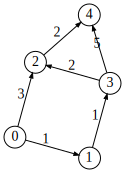

In [341]:
G = DiGraph(5, strict=True)
G.add_edges_from([(0,1,1), (1,3,1), (3,2,2), (3,4,5), (2,4,2), (0,2,3)])
G.view

In [342]:
G.edge_view(0,1).color_on(3) # Error here :TODO

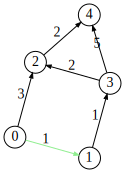

In [343]:
G.view

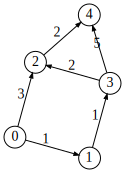

In [344]:
mon_graphe = DiGraph(5)
mon_graphe.add_edges_from([(0,1,1), (1,3,1), (3,2,2), (3,4,5), (2,4,2), (0,2,3)])
mon_graphe.view

In [345]:
explo = Dijkstra(mon_graphe) # Objet Dijkstra

{0: 0, 1: inf, 2: inf, 3: inf, 4: inf}


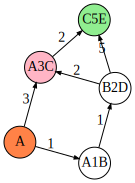

In [346]:
explo.solve()

In [347]:
G1 = Graph()

In [348]:
G1.load_json('G1.json')

In [349]:
DG1 = Dijkstra(G1)

{0: 0, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 7: inf, 8: inf}


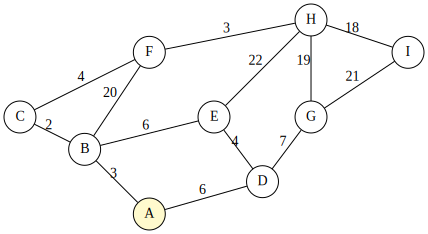

In [350]:
DG1.next()

False
True


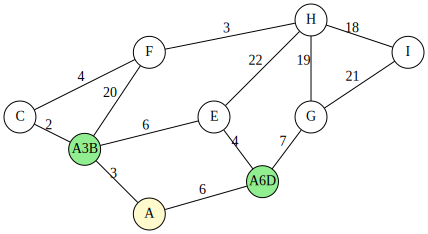

In [351]:
DG1.next()

False
True
False


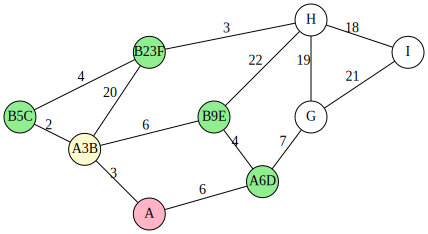

In [352]:
DG1.next()

True


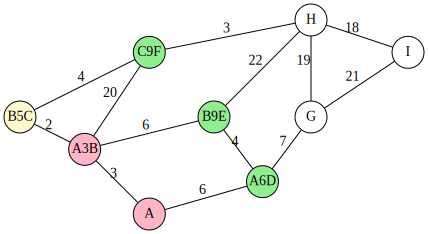

In [353]:
DG1.next()

False


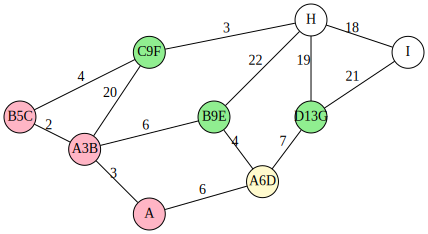

In [354]:
DG1.next()

False


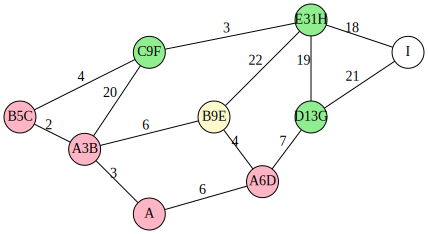

In [355]:
DG1.next()

True


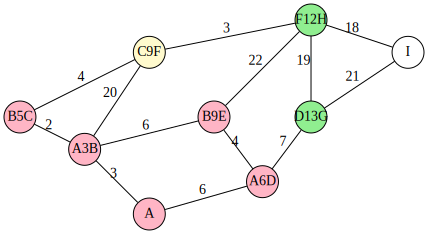

In [356]:
DG1.next()

False


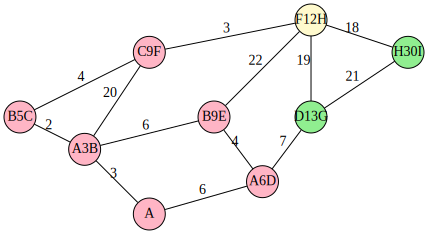

In [357]:
DG1.next()

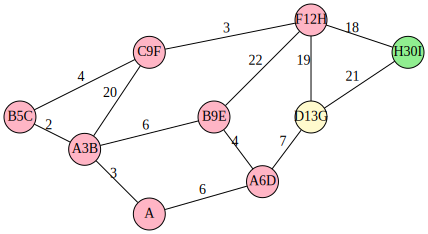

In [358]:
DG1.next()

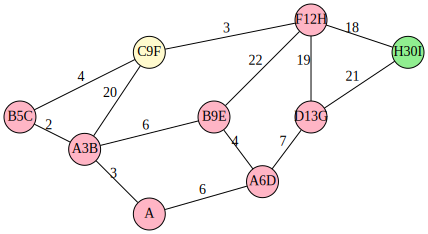

In [359]:
DG1.next()

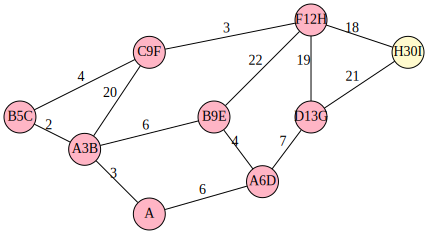

In [360]:
DG1.next()

In [361]:
DG1.next()

Dijkstra résolu


In [362]:
DG1.end

8

In [363]:
DG2 = Dijkstra(G1)

{0: 0, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 7: inf, 8: inf}


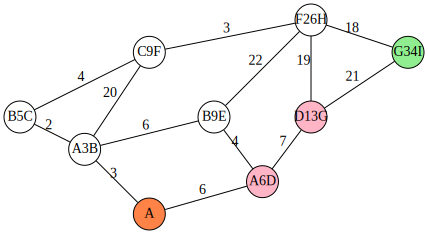

In [364]:
DG2.solve()